<img src="images/python-logo.png" width=400> <img src="images/DSS_logo.png" width=150> 

# <font color=Orange> OpenDSSDirect</font>: Feeder Analysis and Solar Integration
OpenDSSDirect provides a python interface for building, running, and analyzing circuits in OpenDSS. It is a means fo "driving" OpenDSS from outside of the command line interface that we have already learned. It allows the user to develop their own functionalities that may not be included in the standard OpenDSS program and tailor analysis to their research needs. <br>
<br>
Full OpenDSSDirect documentation can be found here --> https://dss-extensions.org/OpenDSSDirect.py/index.html#

## Installation
- First we need to install OpenDSSDirect.py in our current python environment. <br>
- Activate the desired environment and run the following command in a terminal: <font color='orange'> pip install OpenDSSDirect.py[extras] </font> <br>

- Create an instance of OpenDSS in Python and interface to the command line interface in OpenDSS.<br>
 - We can create a shorthand for the <font color='orange'> dss.utils.run_command </font> as <font color='orange'> cmd </font>. This will be our interface for all commands we wish to run in OpenDSS.

In [106]:
import opendssdirect as dss
import matplotlib.pyplot as plt
import numpy as np
import math
import os

cmd = dss.utils.run_command

## Writing commands
We can now use our <font color='orange'> cmd </font> shortcupt to run the same commands we previously learned in the OpenDSS script editor. To <font color='orange'> clear </font> the OpenDSS registers as one should at the beginning of each model, simply type the following command. 

In [107]:
cmd('clear')

''

## Accessing Error Messages
Use a <font color='orange'> reply </font> variableas shown below to to access any error messages raised by OpenDSS. <br>
<br>
Watch what happens below if I try to solve a circuit that is not defined. 

In [108]:
reply1=cmd('clear')
print('reply1:',reply1)

reply2=cmd('solve')
print('reply2:',reply2)

reply1: 
reply2: You must create a new circuit object first: "new circuit.mycktname" to execute this command.


## Building a model
We can build a load flow model in OpenDSS direct by typing out each line of the code, using <font color='orange'> cmd </font> from above. To save time, I will not write out the full model.<br>
<br>
Alternatively, we can use the <font color='orange'> redirect </font> command as shown below. This command will redirect the command interpreter to take input directly from a text file. Once it reaches the end of the text file it will return to the original script from which it was called. 

In [109]:
# manually type out each line if we are building a new model
reply=cmd('clear')
reply1=cmd('set DefaultBaseFrequency=50')
reply2=cmd('new circuit.simple_example_snapshot basekv=132 pu=1.0 angle=0 frequency=50 phases=3')
#etc....
reply3=cmd('solve')
print(reply,reply1,reply2, reply3)

In [110]:
#use redirect command and the directory location of our previously built model.
cmd('clear')
#redirect dss_file_pathname
reply=cmd('redirect '+os.sys.path[0]+'\\OpenDSS_model_files\\Simple_example_snapshot.dss')
print(reply)

## Retrieving Results
Let's start with some simple numbers from out snapshot analysis. Print out total power, loads, bus voltages, and line loadings and plot our voltage profile.<br>
<br>
We will use the following modules from OpenDSSDirect to do this:
<font color=orange>
- dss.Loads
- dss.Circuit
- dss.Bus
- dss.Lines
- dss.CktElement 
</font>

Total power delivered to circuit:
	 7209.044767185278 kw 3871.8623762176635 kvar

2  loads on this feeder:
	 Name = primary_load1, kW = 6750.0, kvar = 3269.0
	 Name = secondary_load1, kW = 315.0, kvar = 153.0

6 buses in this feeder:
	 Name = sourcebus, voltage = [75999.54529687471, 75999.54529687602, 75999.54529688018]
	 Name = a, voltage = [18695.80835890892, 18695.808358909555, 18695.808358910508]
	 Name = b, voltage = [18029.800717460494, 18029.800717461298, 18029.800717462764]
	 Name = c, voltage = [18006.607996145147, 18006.607996146053, 18006.60799614772]
	 Name = d, voltage = [216.76114140623787, 216.76114140626413, 216.76114140629142]
	 Name = e, voltage = [208.76999100769564, 208.76999100732945, 208.7699910054486]

3 lines in this feeder:
	 Name = linea-b, normamps = 220.0, line loading = [143.5621906720171, 143.562190672008, 143.56219067195622]
	 Name = lineb-c, normamps = 165.0, line loading = [6.078000062251334, 6.07800006223659, 6.078000062175591]
	 Name = lined-e, normam

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


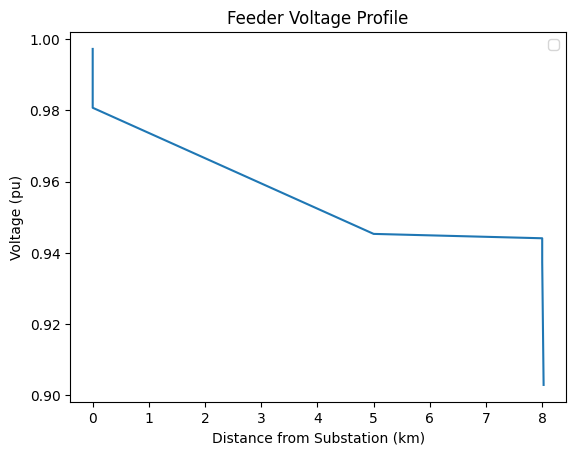

In [111]:
#using dss.Circuit.TotalPower to get kW and kVArs at the substation 
print("Total power delivered to circuit:\n\t", 
    dss.Circuit.TotalPower()[0]*-1,'kw',
    dss.Circuit.TotalPower()[1]*-1,'kvar')

#using the dss.Loads module iterating through the loads in our circuit and printing out the load name, kw, and kVAr for each load. 
print('\n'+str(dss.Loads.Count())," loads on this feeder:")
dss.Loads.First()
while True:
    print('\t Name = {name}, kW = {kW}, kvar = {kvar}'.format(
        name=dss.Loads.Name(),kW=dss.Loads.kW(), kvar=dss.Loads.kvar()))
    if not dss.Loads.Next() > 0:
        break

#using dss.Circuit and dss.Bus modules, we can iterate through all the buses in our circuit and print out the name, phase voltages, and distance from the sub. 
voltage_pu=[]
distance=[]
print('\n'+str(dss.Circuit.NumBuses()), "buses in this feeder:")
for bus in dss.Circuit.AllBusNames():
    dss.Circuit.SetActiveBus(bus)
    print('\t Name = {bus_name}, voltage = {voltage}'.format(
        bus_name=dss.Bus.Name(), 
        voltage=[dss.Bus.VMagAngle()[0], dss.Bus.VMagAngle()[2], dss.Bus.VMagAngle()[4]]
        ))
    distance.append(dss.Bus.Distance())
    voltage_pu.append(dss.Bus.PuVoltage()[0])

#using dss.Lines to iterate through each line segment and print out the line name, its normamps rating, and the line loading.
print('\n'+str(dss.Lines.Count()), 'lines in this feeder:')
dss.Lines.First()
while True:
    print('\t Name = {name}, normamps = {normamps}, line loading = {line_loading}'.format(
        name=dss.Lines.Name(),
        normamps=dss.Lines.NormAmps(), 
        line_loading=[dss.CktElement.CurrentsMagAng()[0],dss.CktElement.CurrentsMagAng()[2], 
        dss.CktElement.CurrentsMagAng()[4]]
        ))
    if not dss.Lines.Next() > 0:
        break

#plotting our voltage profile
fig, ax=plt.subplots()
ax.plot(distance,voltage_pu)
ax.set_title('Feeder Voltage Profile')
ax.set_xlabel('Distance from Substation (km)')
ax.set_ylabel('Voltage (pu)')
ax.legend();

## Timeseries Analysis
Let's <font color=orange>redirect</font> to our timeseries model. 

In [112]:
cmd('clear')
reply=cmd('redirect '+os.sys.path[0]+'\\OpenDSS_model_files\\Simple_example_timeseries.dss')
print(reply)

To perform timeseries analyses we can iterate through each timestep and save metrics at each timestep. Let's plot our loadshape 'daily' and the P and Q at the substation meter. 

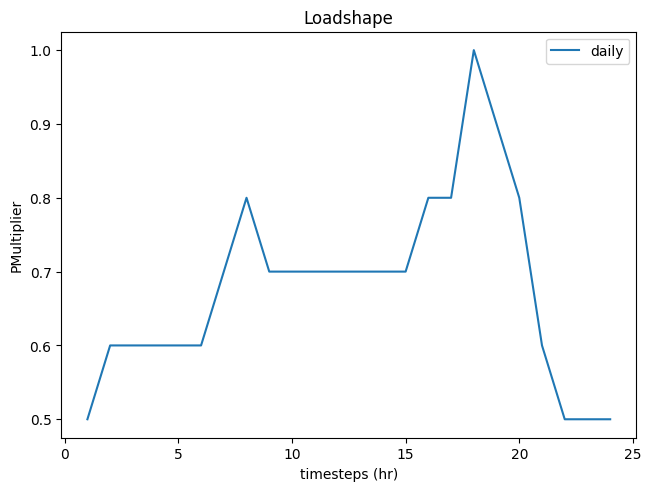

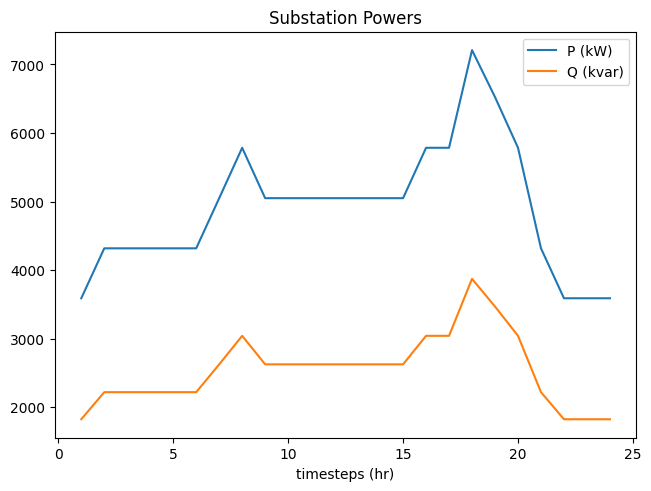

In [113]:
#using dss.LoadShape we can get our loadshape multipliers for each timestep. 
dss.LoadShape.Name('daily')
timesteps=range(1,dss.LoadShape.Npts()+1)
pmultiplier=dss.LoadShape.PMult()

#using dss.Solution, we can solve the model at each timestep and save the values from that solution. Time advances after the dss.Solution.Solve() command. 
kw=[]
kvar=[]
dss.Solution.Hour(0)
for hour in range(1,dss.LoadShape.Npts()+1):
    dss.Solution.Number(1)
    dss.Solution.Solve() # time advances here
    kw.append(-dss.Circuit.TotalPower()[0])
    kvar.append(-dss.Circuit.TotalPower()[1])

#plotting our loadshape
fig, ax=plt.subplots(layout='constrained')
ax.plot(timesteps,pmultiplier, label=dss.LoadShape.Name())
ax.set_title('Loadshape')
ax.set_xlabel('timesteps (hr)')
ax.set_ylabel('PMultiplier')
ax.legend();

#plotting P and Q at the substation meter. 
fig1, ax1=plt.subplots(layout='constrained')
ax1.plot(timesteps,kw, label='P (kW)')
ax1.plot(timesteps,kvar, label='Q (kvar)')
ax1.set_title('Substation Powers')
ax1.set_xlabel('timesteps (hr)')
ax1.legend();

## Timeseries Voltage Analysis
It can be helpful to see the range of voltages at each bus over the timeframe being modeled. Let's plot a box and whisker plot to visualize this. <br>
<br>
Notice that the the source bus voltage does not change much at all, as we made it very stiff.

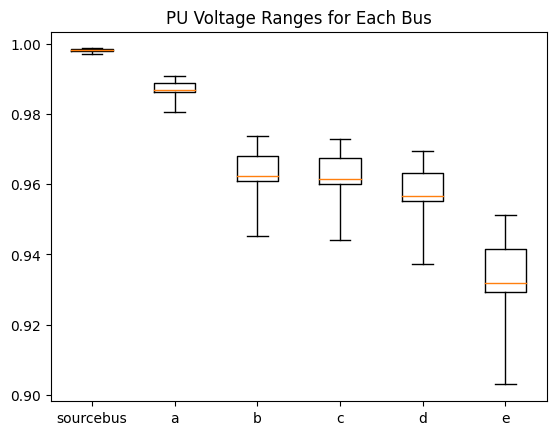

In [114]:
#iterate through the busses in our model, and then iterate through
#each timestep for each bus, saving the per unit voltages in a dictionary
voltage_ts={}
for bus in dss.Circuit.AllBusNames():
    dss.Circuit.SetActiveBus(bus)
    voltage_ts[bus]=[]
    dss.Solution.Hour(0)
    for hour in range(1,dss.LoadShape.Npts()+1):
        dss.Solution.Number(1)
        dss.Solution.Solve()
        voltage_ts[bus].append(dss.Bus.PuVoltage()[0])

#plot the box and whisker plot of bus voltages
fig1,ax1=plt.subplots()
ax1.set_title('PU Voltage Ranges for Each Bus')
ax1.boxplot([v for v in voltage_ts.values()], labels= voltage_ts.keys(), whis=[0,100]);

## Timeseries Loading Analysis
Likewise, it may be useful to the max load of each conductor over our time series as a percent of their normal ampacity rating. Then let's print out all of the linesegments that are overloaded in this scenario. <br>
<br>
NOTE: One can uncomment the first two lines below to add another large load to busC and overload the circuit on purpose. 

In [115]:
# reply=cmd('new load.primary_load2 bus1=C phases=3 kv=33 kw=5400 kvar=2615 model=1 daily=daily status=variable') #6000kVA at pf=0.90
# print('reply:', reply)

#iterate through each line segment, and solve for each timestep saving the currents and the normamps. 
print('Timeseries Line Loadings:')
dss.Lines.First()
overloads=[]
while True:
    maxload=False
    normamps=dss.Lines.NormAmps()
    dss.Solution.Hour(0)
    for hour in range(1,dss.LoadShape.Npts()+1):
        dss.Solution.Number(1)
        dss.Solution.Solve()
        timestep_load=max(dss.CktElement.CurrentsMagAng()[0],
        dss.CktElement.CurrentsMagAng()[2], dss.CktElement.CurrentsMagAng()[4]
        )
        if not maxload:
            maxload=timestep_load
        elif timestep_load>maxload:
            maxload=timestep_load

    #save any overloaded line segments
    if maxload>normamps:
        overloads.append(dss.Lines.Name())
    
    #for each line segment, print our the name, max line loading across all timesteps, and the percentage of the normamps rating. 
    print('Name = {name},\t Max line loading = {max_amps} A, \t Max line loading percent = {maxload_pct} %'.format(
        name=dss.Lines.Name(),max_amps=maxload, maxload_pct=100*maxload/normamps
        ))
    if not dss.Lines.Next() > 0:
        break

#print out any line overloads
print('\nOverloaded line segments:')
for line in overloads:
    print(line)

Timeseries Line Loadings:
Name = linea-b,	 Max line loading = 143.56021989512232 A, 	 Max line loading percent = 65.25464540687378 %
Name = lineb-c,	 Max line loading = 6.077907577103473 A, 	 Max line loading percent = 3.6835803497596804 %
Name = lined-e,	 Max line loading = 503.499458952063 A, 	 Max line loading percent = 87.56512329601095 %

Overloaded line segments:


We just changed our active circuit by adding a new load! Even by commenting out that line in our code, the new load will still be in our OpenDSS model.<br>
<br>
Let's just clear the changes we made previously, with our additional load so we can continue analyzing our original model. Just use the <font color=orange> clear</font> command and <font color=orange>redirect</font> to reload the original model.

In [116]:
cmd('clear')
reply=cmd('redirect '+os.sys.path[0]+'\\OpenDSS_model_files\\Simple_example_timeseries.dss')
print(reply)

## Timeseries Loss Assessment
One can also look at the losses over each timestep in our simulation. This can be useful if we want to monetize our loss metrics and visualize lost revenue. The plots below show losses at each timestep, cumulative losses over our simulation timeframe, and cumulative lost revenue over the simulation timeframe. 
<br>
<br>
Let's use ₹8/kWh.

-3588.5822908993614


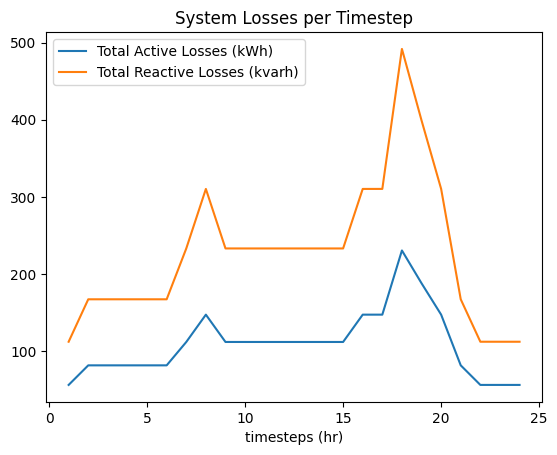

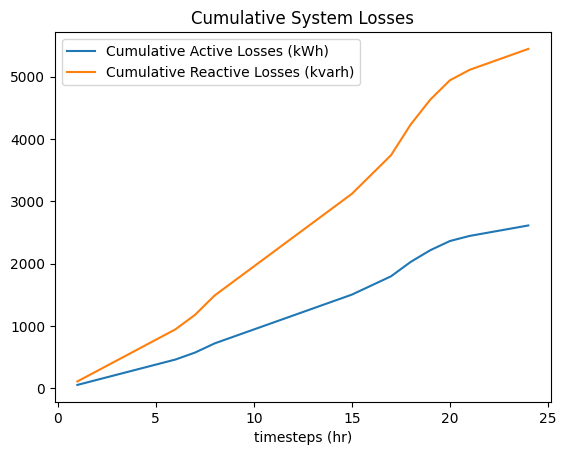

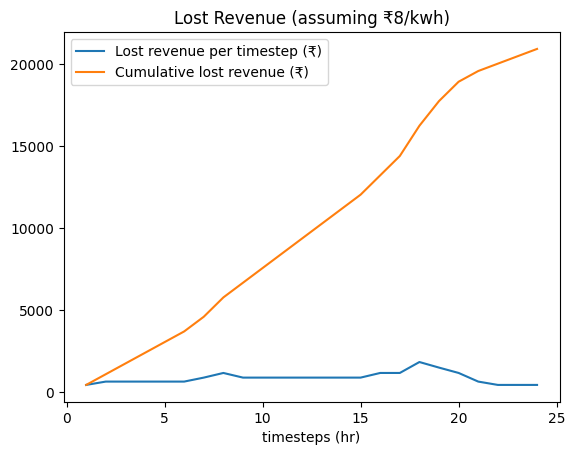

In [118]:
active_losses=[]
reactive_losses=[]
energy_consumption=[]

#iterate through each timestep and save the active and reactive losses as well 
#as the energy consumption for that timestep. 
timesteps=range(1,dss.LoadShape.Npts()+1)
dss.Solution.Hour(0)
for hour in range(1,dss.LoadShape.Npts()+1):
    dss.Solution.Number(1)
    dss.Solution.Solve()
    active_losses.append(dss.Circuit.Losses()[0]/1000)
    reactive_losses.append(dss.Circuit.Losses()[1]/1000)
    energy_consumption.append(-dss.Circuit.TotalPower()[0])


#calculate cumulative losses
cumulative_active_losses=np.cumsum(np.asarray(active_losses))
cumulative_reactive_losses=np.cumsum(np.asarray(reactive_losses))
cumulative_energy_consumption=np.cumsum(np.asarray(energy_consumption))

#assign a price per kwh and calculate lost revenue and total revenue
price_kwh=8 #rupees
lost_revenue=np.asarray(active_losses)*price_kwh
cumulative_lost_revenue=np.cumsum(lost_revenue)
total_revenue=cumulative_energy_consumption[-1]*price_kwh

#plot losses for each timestep
fig,ax=plt.subplots()
ax.set_title('System Losses per Timestep')
ax.plot(timesteps, active_losses, label='Total Active Losses (kWh)')
ax.plot(timesteps, reactive_losses, label='Total Reactive Losses (kvarh)');
ax.set_xlabel('timesteps (hr)')
ax.legend();

#plot cumulative losses at each timestep
fig1,ax1=plt.subplots()
ax1.plot(timesteps, cumulative_active_losses, label='Cumulative Active Losses (kWh)')
ax1.plot(timesteps, cumulative_reactive_losses, label='Cumulative Reactive Losses (kvarh)')
ax1.set_title('Cumulative System Losses')
ax1.set_xlabel('timesteps (hr)')
ax1.legend();

#plot Cumulative lost revenue
fig2,ax2=plt.subplots()
ax2.plot(timesteps, lost_revenue, label='Lost revenue per timestep (₹)')
ax2.plot(timesteps, cumulative_lost_revenue, label='Cumulative lost revenue (₹)')
ax2.set_title('Lost Revenue (assuming ₹{price}/kwh)'.format(price=price_kwh))
ax2.set_xlabel('timesteps (hr)')
ax2.legend();

We can also print the total lost revenue as a percent of total revenue.

In [119]:
lost_rev_pct=round(cumulative_lost_revenue[-1]/total_revenue,3)
print('Lost revenue = '+str(round(lost_rev_pct*100,3))+"% of total revenue")

Lost revenue = 2.2% of total revenue


## Distributed Generation
Let us now add our solar system as shown in the oneline from yesterday's tutorial. This can be done with the commands below.<br>
<br>
NOTE: We are using a different loadshape that mimics irradiance data for our solar system! Let's print out the solar curve to compare to our load shape. <br>
<br>
<br>
<img src="images\Oneline.jpg" width=700>

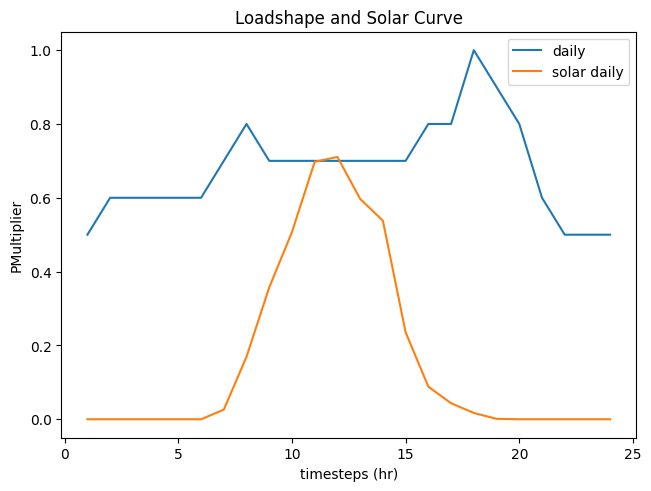

In [120]:
#add a new loadshape called solar_daily
reply1=cmd('new loadshape.solar_daily npts=24 interval=1.0 csvfile='+os.sys.path[0]+'\\OpenDSS_model_files\\solar_daily.txt')

#add new pvsystem with a nameplate and pmpp of 3 MVA at unity PF
reply2=cmd('new pvsystem.pv1 bus1=C phases=3 kv=33 kva=3000 irradiance=0.98 pmpp=3000 kvar=0 %cutin=0.05 %cutout=0.05 daily=solar_daily')
print(reply1, reply2)

#print our loadshape and pv curve
dss.LoadShape.Name('daily')
timesteps=range(1,dss.LoadShape.Npts()+1)
pmultiplier=dss.LoadShape.PMult()
dss.LoadShape.Name('solar_daily')
pvmultiplier=dss.LoadShape.PMult()

fig, ax=plt.subplots(layout='constrained')
ax.plot(timesteps,pmultiplier, label='daily')
ax.plot(timesteps,pvmultiplier, label='solar daily' )
ax.set_title('Loadshape and Solar Curve')
ax.set_xlabel('timesteps (hr)')
ax.set_ylabel('PMultiplier')
ax.legend();

## PV Voltage Analysis
Let's look at how our solar system affects the feeder's voltage profile. 

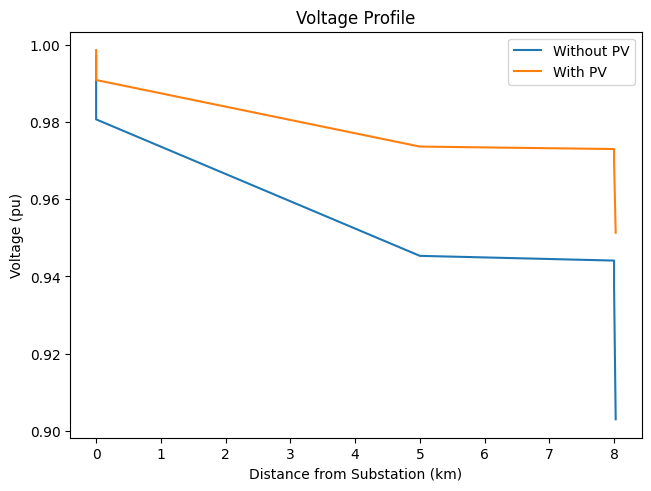

In [121]:
#iterate through each bus of collecting the per unit voltage for the last timestep of our model. 
voltage_pu_solar=[]
for bus in dss.Circuit.AllBusNames():
    dss.Circuit.SetActiveBus(bus)
    voltage_pu_solar.append(dss.Bus.PuVoltage()[0])

#plot voltage over distance
fig, ax=plt.subplots(layout='constrained')
ax.plot(distance,voltage_pu, label='Without PV')
ax.plot(distance, voltage_pu_solar, label='With PV')
ax.set_title('Voltage Profile')
ax.set_xlabel('Distance from Substation (km)')
ax.set_ylabel('Voltage (pu)')
ax.legend();

## PV Load Analysis
Let's see how our PV affects feeder loading. Let's plot out both of our loadshapes and then the feeder-level P and Q with and without solar. 

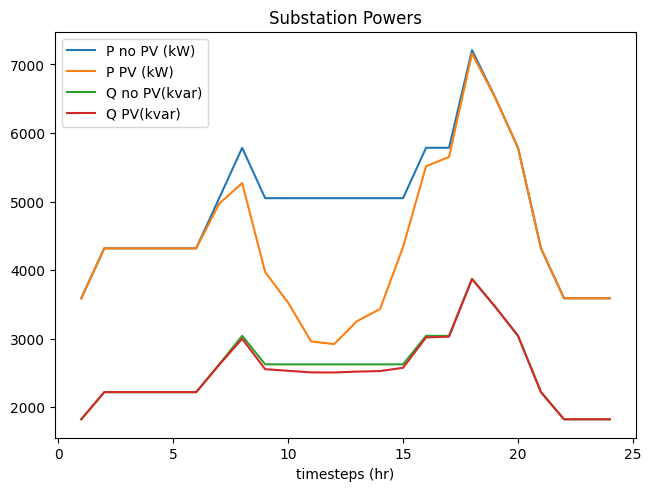

In [123]:
#iterate through each timestep, recording P and Q at the substation meter with solar. 
kw_solar=[]
kvar_solar=[]
dss.Solution.Hour(0)
for hour in range(1,dss.LoadShape.Npts()+1):
    dss.Solution.Number(1)
    dss.Solution.Solve() # the advancing happens here
    kw_solar.append(-dss.Circuit.TotalPower()[0])
    kvar_solar.append(-dss.Circuit.TotalPower()[1])

#plot P and Q with and without solar. 
fig, ax=plt.subplots(layout='constrained')
ax.plot(timesteps,kw, label='P no PV (kW)')
ax.plot(timesteps,kw_solar, label='P PV (kW)')
ax.plot(timesteps,kvar, label='Q no PV(kvar)')
ax.plot(timesteps,kvar_solar, label='Q PV(kvar)')
ax.set_title('Substation Powers')
ax.set_xlabel('timesteps (hr)')
ax.legend();

## PV Bus Voltage Analysis
Let's visualize the range of voltages seen at each bus with and without PV.

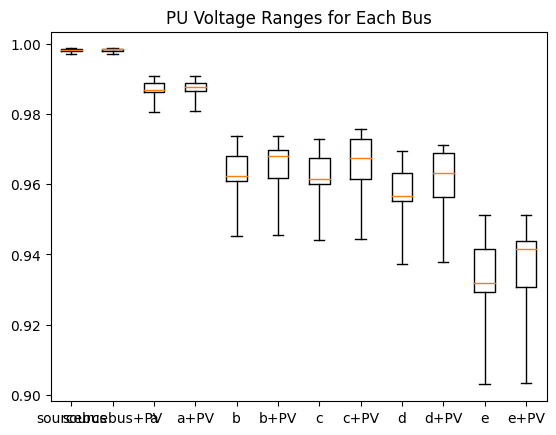

In [124]:
#iterate through the busses in our model, and then iterate through each timestep for each bus, saving the per unit voltages in a dictionary
voltage_ts_solar={}
for bus in dss.Circuit.AllBusNames():
    dss.Circuit.SetActiveBus(bus)
    voltage_ts_solar[bus]=[]
    dss.Solution.Hour(0)
    for hour in range(1,dss.LoadShape.Npts()+1):
        dss.Solution.Number(1)
        dss.Solution.Solve()
        voltage_ts_solar[bus].append(dss.Bus.PuVoltage()[0])

#plot voltage ranges for each bus with and without solar
combined_voltage_ts={}
for index, (key,value) in enumerate(voltage_ts.items()):
    combined_voltage_ts[key]=value
    combined_voltage_ts[str(key)+'+PV']=voltage_ts_solar[key]

fig1,ax1=plt.subplots()
ax1.set_title('PU Voltage Ranges for Each Bus')
ax1.boxplot([v for v in combined_voltage_ts.values()], labels= combined_voltage_ts.keys(), whis=[0,100]);

## PV Loss Assessment
How does PV affect system losses and revenue?

total_revenue: 940123.7843733166
total_revenue_solar: 844178.7611949346


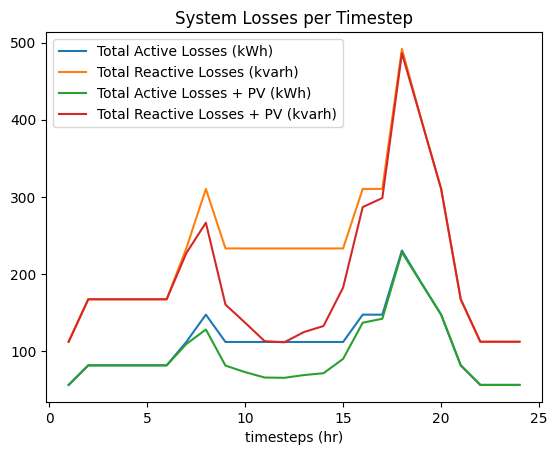

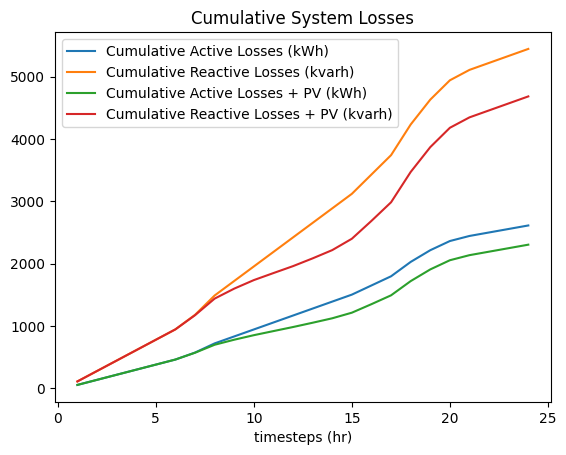

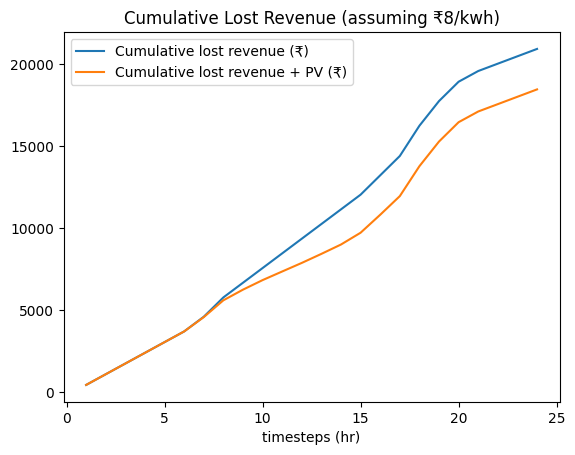

In [125]:
import numpy as np

active_losses_solar=[]
reactive_losses_solar=[]
energy_consumption_solar=[]
dss.Solution.Hour(0)
for hour in range(1,dss.LoadShape.Npts()+1):
    dss.Solution.Number(1)
    dss.Solution.Solve()
    active_losses_solar.append(dss.Circuit.Losses()[0]/1000)
    reactive_losses_solar.append(dss.Circuit.Losses()[1]/1000)
    energy_consumption_solar.append(-dss.Circuit.TotalPower()[0])

cumulative_active_losses_solar=np.cumsum(np.asarray(active_losses_solar))
cumulative_reactive_losses_solar=np.cumsum(np.asarray(reactive_losses_solar))
cumulative_energy_consumption_solar=np.cumsum(np.asarray(energy_consumption_solar))

price_kwh=8 #ruppees
lost_revenue_solar=np.asarray(active_losses_solar)*price_kwh
cumulative_lost_revenue_solar=np.cumsum(lost_revenue_solar)
total_revenue_solar=cumulative_energy_consumption_solar[-1]*price_kwh
print('total_revenue:',total_revenue)
print('total_revenue_solar:',total_revenue_solar)

fig,ax=plt.subplots()
ax.plot(timesteps, active_losses, label='Total Active Losses (kWh)')
ax.plot(timesteps, reactive_losses, label='Total Reactive Losses (kvarh)');
ax.plot(timesteps, active_losses_solar, label='Total Active Losses + PV (kWh)')
ax.plot(timesteps, reactive_losses_solar, label='Total Reactive Losses + PV (kvarh)');
ax.set_xlabel('timesteps (hr)')
ax.set_title('System Losses per Timestep')
ax.legend();

fig1,ax1=plt.subplots()
ax1.plot(timesteps, cumulative_active_losses, label='Cumulative Active Losses (kWh)')
ax1.plot(timesteps, cumulative_reactive_losses, label='Cumulative Reactive Losses (kvarh)')
ax1.plot(timesteps, cumulative_active_losses_solar, label='Cumulative Active Losses + PV (kWh)')
ax1.plot(timesteps, cumulative_reactive_losses_solar, label='Cumulative Reactive Losses + PV (kvarh)')
ax1.set_xlabel('timesteps (hr)')
ax1.set_title('Cumulative System Losses')
ax1.legend();

fig2,ax2=plt.subplots()
ax2.plot(timesteps, cumulative_lost_revenue, label='Cumulative lost revenue (₹)')
ax2.plot(timesteps, cumulative_lost_revenue_solar, label='Cumulative lost revenue + PV (₹)')
ax2.set_title('Cumulative Lost Revenue (assuming ₹{price}/kwh)'.format(price=price_kwh))
ax2.set_xlabel('timesteps (hr)')
ax2.legend();

## Simple Hosting Capacity Study
A solar developer wants to know how much hosting capacity the feeder has, specifically on BusC where they have purchased land to build a solar farm. <br>
<br>
To answer this question, we can incrementally increase our pv system interconnecting to busC and check for violations at each step. 
In this very simple analysis we will check for three types of violations:<br>
- Overvoltage 
- Conductor overload
- Reverse powerflow at the substation (kw) <br>


We will print out the first violation that occurs and at what pv size upgrades would be necessary. <br>
<br>We can comment out certain checks below if we don't want to evaluate by that criteria. 

DG size = 7300: 	 Reverse power flow at the subsation, -41.811064207596786 kw, 1823.0708849292384 kvar


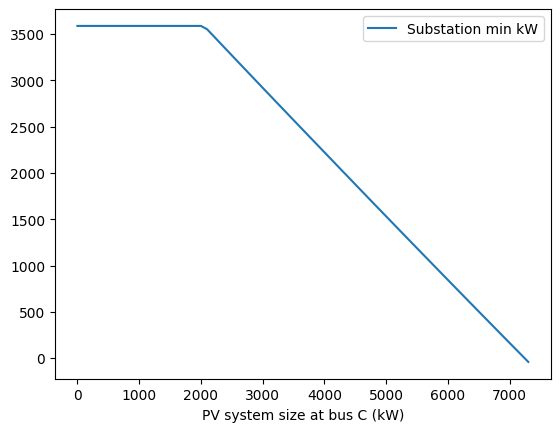

In [16]:
#set out overvoltage threshold and PV system step size
ov_threshold=1.05
dg_kw_increment=100

#initialize our dg set point at 0 kW and set all of our checks to false. 
dg_kw_set=0 #kw
voltage_violation=False
line_overload=False
reverse_power_flow=False

#create empty lists for our key metrics. 
time_step_max_bus_voltages=[]
time_step_max_line_loadings=[]
time_step_substation_kw=[]
time_step_substation_kvar=[]
dg_increments=[]

#using a while loop, we will keep increasing the pv system size until one of the three criteria is met (overvoltage, line overload, or reverse power flow)
while not voltage_violation and not line_overload and not reverse_power_flow:

    #clear the register, redirect to our timeseries model, and add a pv system and loadshape of the current step's size.
    cmd('clear')
    cmd('redirect '+os.sys.path[0]+'\\OpenDSS_model_files\\Simple_example_timeseries.dss')
    cmd('new loadshape.solar_daily npts=24 interval=1.0 csvfile='+os.sys.path[0]+'\\OpenDSS_model_files\\solar_daily.txt')
    cmd('new pvsystem.pv1 bus1=C phases=3 kv=33 kva={kva} irradiance=0.98 pmpp={pmpp} kvar=0 %cutin=0.05 %cutout=0.05 daily=solar_daily'.format(kva=dg_kw_set, pmpp=dg_kw_set))
    
    max_bus_voltage=False
    maxload_pct=False
    min_kw=False
    min_kvar=False

    #iterate through timestep
    dss.Solution.Hour(0)
    for hour in range(1,dss.LoadShape.Npts()+1):
        dss.Solution.Number(1)
        dss.Solution.Solve()

        #find max bus voltage for current timestep
        for bus in dss.Circuit.AllBusNames():
            dss.Circuit.SetActiveBus(bus)
            bus_voltage=dss.Bus.PuVoltage()[0]
            if not max_bus_voltage:
                max_bus_voltage=bus_voltage
                max_voltage_bus_name=bus
            elif bus_voltage>max_bus_voltage:
                max_bus_voltage=bus_voltage
                max_voltage_bus_name=bus
        
        #find max line loadings for current timestep
        dss.Lines.First()
        while True:
            line_load_pct=max(dss.CktElement.CurrentsMagAng()[0],dss.CktElement.CurrentsMagAng()[2], dss.CktElement.CurrentsMagAng()[4])/dss.Lines.NormAmps()
            if not maxload_pct:
                maxload_pct=line_load_pct/dss.Lines.NormAmps()
                maxload_line=dss.Lines.Name()
            elif line_load_pct>maxload_pct:
                maxload_pct=line_load_pct
                maxload_line=dss.Lines.Name()
            if not dss.Lines.Next() > 0:
                break

        #find total power flow at substion
        time_step_kw=-dss.Circuit.TotalPower()[0]
        time_step_kvar=-dss.Circuit.TotalPower()[1]
        if not min_kw:
            min_kw=time_step_kw
        elif time_step_kw<min_kw:
            min_kw=time_step_kw
        if not min_kvar:
            min_kvar=time_step_kvar
        elif time_step_kvar<min_kvar:
            min_kvar=time_step_kvar

    #add current iteration metrics to plotting data
    time_step_max_bus_voltages.append(max_bus_voltage)
    time_step_max_line_loadings.append(maxload_pct)
    time_step_substation_kw.append(min_kw)
    time_step_substation_kvar.append(min_kvar)
    dg_increments.append(dg_kw_set)

    # Run checks for current circuit. COMMENT OUT TWO OF THESE CHECKS TO ONLY RUN ONE
    # 1. Check for line overloads
    if maxload_pct>1:
        print('DG size = {dg}: \t Line overload at line section {name}, {loading}% normamps'.format(dg=dg_kw_set, name=maxload_line, loading=maxload_pct*100))
        line_overload=True
        fig,ax=plt.subplots()
        ax.plot(dg_increments, time_step_max_line_loadings, label='Max Line Loadings (percent of conductor ampacity)')
        ax.set_xlabel('PV system size at bus C (kW)')
        ax.legend();

    # 2. Check for overvoltages
    if max_bus_voltage>ov_threshold:
        print('DG size = {dg}: \t Voltage violation at bus {name}, {bus_voltage} pu'.format(dg=dg_kw_set, name=max_voltage_bus_name, bus_voltage=max_bus_voltage))
        voltage_violation=True
        fig,ax=plt.subplots()
        ax.plot(dg_increments, time_step_max_bus_voltages, label='Max bus voltage (pu)')
        ax.set_xlabel('PV system size at bus C (kW)')
        ax.legend();


    # 3. Check for reverse power flow at the substation
    if min_kvar < 0 or min_kw < 0:
        print('DG size = {dg}: \t Reverse power flow at the subsation, {kw} kw, {kvar} kvar'.format(dg=dg_kw_set, kw=min_kw, kvar=min_kvar))
        reverse_power_flow=True
        fig,ax=plt.subplots()
        ax.plot(dg_increments, time_step_substation_kw, label='Substation min kW')
        ax.set_xlabel('PV system size at bus C (kW)')
        ax.legend();

    #increase solar system size by specified increment if no checks were failed
    dg_kw_set+=dg_kw_increment